In [1]:
import numpy as np
import constants
import quaternion as qt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Цель - реализовать модель солнечного давления
Формула для силы солнечного давления, действующая на единичну площадь:
$$
d\textbf{F}=-\frac{Ф_0}{c}\Big(\frac{Au}{r}\Big)^2(\textbf{r}_s,\;\textbf{n})\big((1-\alpha)\textbf{r}_s+
2\alpha\mu(\textbf{r}_s,\;\textbf{n})\textbf{n}+\alpha(1-\mu)(\textbf{r}_s+\frac{2}{3}\textbf{n})\big)dS
$$
Рассматривается случай плоской пластины.  
С силой, действующей на центр масс всё понятно - в формуле выше убрать d слева и справа.  
Но центр масс может не совпадать с геометрическим центром пластины, поэтому момент, в общем случае, будет не нулевой.
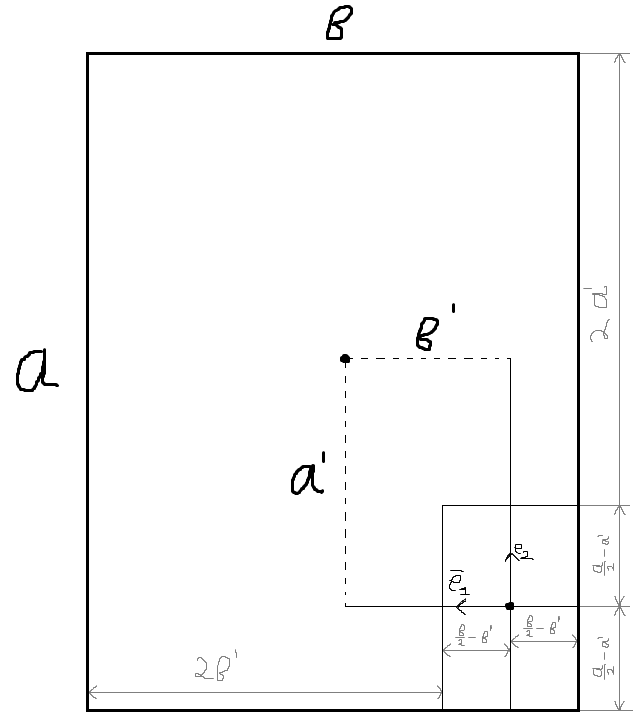
Вектор ЦМ (центр масс) - ЦП (центр пластины):
$$
\textbf{r}_{cm-cp}=
\begin{pmatrix}
b'\\
a'\\
с'
\end{pmatrix}\\
b'\in\big[-\frac{b}{2},\frac{b}{2}\big],\:a'\in\big[-\frac{a}{2},\frac{a}{2}\big]
$$
Силу d**F** можно разделить на две компоненты: d**F1**, коя направлена по **n**, и d**F2** - направлена по **r**<sub>s</sub>  
$$
d\textbf{F}_1:=f_1\textbf{n}\:dS=f_1\textbf{n}\:dx\:dy\\
d\textbf{F}_2:=f_2\textbf{r}_s\:dS=f_2\textbf{r}_sdx\:dy\\
\textbf{r}_s\;and\;\textbf{n}=
\begin{pmatrix}
0\\
0\\
\pm1
\end{pmatrix}
\;must\:be\:in\:BOUNDED\:system\;(\pm\;is\:because\:of\:presence\:of\:two\:normals)\\
d\textbf{M}=[\textbf{R}, d\textbf{F}]=[\textbf{r}_{cm-cp}+\textbf{p}, d\textbf{F}]\\
\int_{plate}{}{\textbf{p}dS}=0\\
\textbf{M}=\int_{plate}{}{[\textbf{r}_{cm-cp},f_1\:\textbf{n}+f_2\textbf{r}_s]dS}=
[\int_{plate}{}{\textbf{r}_{cm-cp}dS},\:f_1\textbf{n}+f_2\textbf{r}_s]=
[
\begin{pmatrix}
a\cdot b\cdot b'\\
a\cdot b\cdot a'\\
a\cdot b\cdot c'
\end{pmatrix}
,\:f_1\textbf{n}+f_2\textbf{r}_s]=
ab\:[\textbf{r}_{cm-cp},\:f_1\textbf{n}+f_2\textbf{r}_s]\\
\textbf{v}_1:=[\textbf{r}_{cm-cp},\:\textbf{n}]\\
\textbf{v}_2:=[\textbf{r}_{cm-cp},\:\textbf{r}_s]\\
\:\\
\:\\
\textbf{Finally}\\
\textbf{M}=ab\:(f_1\textbf{v}_1+f_2\textbf{v}_2)\\
\:\\
Where\\
f_0:=\frac{Ф_0}{c}Au^2\\
f_1=-f_0\frac{(\textbf{r}_s,\;\textbf{n})}{r^2}\big(1-\alpha\mu\big)\\
f_2=-2\alpha f_0\frac{(\textbf{r}_s,\;\textbf{n})}{r^2}\big(\mu\:(\textbf{r}_s,\;\textbf{n})+\frac{1-\mu}{3}\big)
$$

In [2]:
def RK4(f, x0x1, y0, step, save_steps :int = 1, step_process = lambda y: y):
    # f MUST takes x and y as arguments: f(x, y)
    # It solves equation y' = f(x, y), y(x0) = y0 (everything is a vector)
    # from x0x1[0] to x0x1[1] on the grid with step step
    # save_steps - INT >= 1; integrator will save results every save_steps steps (2 - every second step, 1 - every step, etc.)
    # save_steps doesn't affect starting point and final point
    # step_process - FUNCTION that is called after every step to somehow process results (normalization and so on)
    # step_process - must take y argument (for single time step) as input and return the same shape numpy.ndarray
    # by default it doesn't do anything
    # returns array of (x, y) pairs
    if not isinstance(save_steps, int):
        raise TypeError("save_steps MUST be an integer")
    elif save_steps <= 0:
        raise ValueError("save_steps MUST be a natural number (1, 2, 3, ...)")
    
    x0 = x0x1[0]
    x1 = x0x1[1]
    current_x = np.array(x0, dtype = np.float64)
    current_y = np.array(y0, dtype = np.float64)
    result = [[x0, *y0]]
    h = step
    h2 = h/2
    h6 = h/6
    stop = x1 - h
    ind = 0
    while current_x < stop:
        ind += 1
        k1 = np.array(f(current_x, current_y))
        k2 = np.array(f(current_x + h2, current_y + k1*h2))
        k3 = np.array(f(current_x + h2, current_y + k2*h2))
        k4 = np.array(f(current_x + h, current_y + k3*h))
        current_y += h6*(k1 + 2*k2 + 2*k3 + k4)
        current_y = step_process(current_y)
        current_x += h
        if ind == save_steps:
            result.append(np.array([current_x.copy(), *current_y.copy()]))
            ind = 0

    if current_x < x1 - constants.max_to_zero:
        h = x1 - current_x
        h2 = h/2
        h6 = h/6
        k1 = np.array(f(current_x, current_y))
        k2 = np.array(f(current_x + h2, current_y + k1*h2))
        k3 = np.array(f(current_x + h2, current_y + k2*h2))
        k4 = np.array(f(current_x + h, current_y + k3*h))
        current_y += h6*(k1 + 2*k2 + 2*k3 + k4)
        current_y = step_process(current_y)
        current_x += h
        result.append(np.array([current_x.copy(), *current_y.copy()]))       
    
    return np.array(result)


class parameters:
    pass

J = np.zeros((3, 3))
J[0,0] = 1
J[1, 1] = 3
J[2, 2] = 2
Jinv = np.linalg.inv(J)

params = parameters()
params.J = J
params.Jinv = Jinv
params.grav_mu = constants.muE
params.a = 1
params.b = 2
params.S = params.a * params.b
params.rcmcp = [0.5, 1, 0.3] # radius vector from center of masses to the geometrical center
params.alpha = 0.5
params.mu = 0.05
params.rse = np.array([0, 0, 1]) # unit Earth-Sun in inertial system

In [3]:
f0 = constants.solar_const / constants.c * constants.au**2

def InShadow(r, rse):
    # checks whether SC is in Earths cylindrical shadow
    # r - Earth-SC radius vector (np.ndarray)
    # rse - Earth-Sun unit radius vector (np.ndarray)
    # r and rse must be in one system
    sp = np.dot(r, rse)
    h = r - sp * rse
    h = np.linalg.norm(h)
    if h >= constants.RE:
        return False
    elif sp < 0:
        return True

def SolarTorque(t, r, V, we, A, Ainv, rse, rcmcp, S, alpha, mu, dse = constants.au):
    # returns torque in BOUNDED system
    # for a flat plate with width = b (along e1 bounded axis) and height = a (along e2 bounded axis); m
    # center of plate is (acp, bcp, 0) regarding to the center of masses; m
    # takes r, V in inertial reference system; m, m/s
    # w, A in bounded system as arrays; radiand/s
    # rse - Earth-Sun unit radius vector (np.ndarray) in INERTIAL
    # dse - distance from Earth to Sun; m
    # alpha, mu - parameters of the surface
    global f0
    res = np.zeros(3)
    
    if InShadow(r, rse):
        return res
    else:
        n = np.array([0, 0, 1]) # in bounded system
        rsd = dse * rse - r
        rsdd = np.linalg.norm(rsd)
        rs = rsd/rsdd # unit vector in inertial
        rs = (Ainv * np.quaternion(*rs) * A).vec # in bounded
        
        rsn = np.dot(rs, n)
        n = n if rsn >=0 else -n # choosing the illuminated side
        
        v1 = np.cross(rcmcp, n)
        v2 = np.cross(rcmcp, rs)
        
        f1 = -f0 * rsn / rsdd**2 * (1 - alpha * mu)
        f1 = f1 * v1
        f2 = -2 * alpha * f0 * rsn / rsdd**2 * (mu * rsn + (1 - mu)/3)
        f2 = f2 * v2
        res = S * (f1 + f2)
        return res
    
def GravTorque(t, r, V, we, A, Ainv, mu = constants.muE):
    # xe = ST * xi = A.inverse * xi * A
    # takes r, V in inertial reference system
    # w, A in bounded system; A as quaternion!
    # Conversion is supposed to be carried out in overlying function
    # returns gravitational torque IN BOUNDED basis
    rr = np.linalg.norm(r)
    e3 = r / rr # in ifr
    e3 = (Ainv * np.quaternion(*e3) * A).vec # convertion to bounded basis
    Me = 3 * mu / rr**3 * np.cross(e3, params.J @ e3)
    return Me


def Torque(t, r, V, we, A, params):
    # xe = ST * xi = A.inverse * xi * A
    # takes r, V in inertial reference system
    # w, A in bounded system as arrays
    # returns torque IN BOUNDED basis
    A = np.quaternion(*A)
    Ainv = A.inverse()
    M = np.zeros(3)
    M += GravTorque(t, r, V, we, A, Ainv)
    M += SolarTorque(t, r, V, we, A, Ainv, 
                     params.rse, params.rcmcp, params.S ,params.alpha, params.mu)
    return M

def QuatDot(Ai, we):
    return np.quaternion(*Ai) * np.quaternion(*we) * 0.5

def Euler(t, r, V, we, A, params, M = lambda t, r, V, we, A: np.array([0, 0, 0])):
    # return w' accroding to Euler's dinamic equation
    # A - orientation QUATERNION
    # M(t, w, A) - function of external moment in bounded axes
    return params.Jinv @ (M(t, r, V, we, A, params) - np.cross(we, params.J @ we))


def SolarForce(t, r, V, we, A, Ainv, rse, alpha, mu, S, dse = constants.au):
    # returns force in INERTIAL system
    # takes r, V in inertial reference system; m, m/s
    # w, A in bounded system as arrays; radiand/s
    # rse - Earth-Sun unit radius vector (np.ndarray) in INERTIAL
    # dse - distance from Earth to Sun; m
    # alpha, mu - parameters of the surface
    # S - surface area; m^2
    global f0
    res = np.zeros(3)
    n = np.array([0, 0, 1]) # in bounded system
    n = (A * np.quaternion(*n) * Ainv).vec # in inertial
    
    if InShadow(r, rse):
        return res
    else:
        rsd = dse * rse - r
        rsdd = np.linalg.norm(rsd)
        rs = rsd/rsdd # unit vector
        
        rsn = np.dot(rs, n)
        n = n if rsn >=0 else -n # choosing the illuminated side
        
        f1 = -f0 * rsn / rsdd**2 * (1 - alpha * mu)
        f1 = f1 * rs
        f2 = -2 * alpha * f0 * rsn / rsdd**2 * (mu * rsn + (1 - mu)/3)
        f2 = f2 * n
        res = (f1 + f2) * S
        return res

def GravForce(t, r, mu = constants.muE):
    # Returns gravitational force in inertial system; m/s^2
    # r in INERTIAL; m
    return -mu * r / np.linalg.norm(r)**3

def f(t, x, params):
    # x[:3] - r, x[3:6] - V, x[6:9] - we, x[9:] - Ai
    r = x[:3]
    V = x[3:6]
    we = x[6:9]
    A = x[9:]
    
    res = np.empty(13)
    res[:3] = V
    
    s = SolarForce(t, r, V, we, np.quaternion(*A), np.quaternion(*A).inverse(), 
                   params.rse, params.alpha, params.mu, params.S)
    g = GravForce(t, r)
    
    res[3:6] = g + s
    res[6:9] = Euler(t, r, V, we, A, params, Torque)
    res[9:] = QuatDot(A, we).components
    return res

def normalization(x):
    x[9:] /= np.linalg.norm(x[9:])
    return x

In [4]:
%%time
t0 = 0
t1 = 92*60
step = 0.1

r0 = np.array([1, 0, 0]) * (constants.RE + constants.ISS_periapsis)
# хочу круговую орбиту
V0 = np.array([0 , 1, 0]) * np.sqrt(params.grav_mu/np.linalg.norm(r0))
we0 = np.array([0.01, 0.01, 0.01])
A0 = np.quaternion(0.5, 0.5, 0.5, 0.5) # ОСК и ССК совпадают

x0 = np.hstack((r0, V0, we0, A0.components))

resultang = RK4(lambda t, x: f(t, x, params), (t0, t1), x0, step, step_process = normalization)

Wall time: 51.2 s


In [5]:
timepoints = resultang[:, 0]
r = resultang[:, 1:4]
V = resultang[:, 4:7]
we = resultang[:, 7:10]
A = resultang[:, 10:]

E3 = np.array([i / np.linalg.norm(i) for i in r])

E1 = np.array([(i - j * np.dot(i, j)) for i, j in zip(V, E3)])
for i in range(E1.shape[0]):
    E1[i] /= np.linalg.norm(E1[i])

E2 = np.array([np.cross(i, j) for i, j in zip(E3, E1)])

S1 = np.array([np.array([E1[i], E2[i], E3[i]]) for i in range(E1.shape[0])]) # матрицы перехода ИСК -> ОСК x' = Sx (НЕ линал)
S2 = np.array([qt.as_rotation_matrix(np.quaternion(*i)).T for i in A]) # матрицы перехода ИСК -> ССК x' = Sx (НЕ линал)
S3 = np.array([j @ i.T for i, j in zip(S1, S2)]) # матрицы перехода ОСК -> ССК x' = Sx (НЕ линал)
A3 = np.array([qt.from_rotation_matrix(i.T).components for i in S3]) # кватернионы поворота ОСК -> CCК

# Сделаю компоненты кватерниона более гладкими (а то у них знак скачет туда-сюда)
# Мой костыльный метод дальше, когда равновесие искать буду
tol = 0.1
for i in range(1, A3.shape[0]):
    if np.linalg.norm(A3[i] - A3[i-1]) > tol:
        # Если сильно меняется норма - то произошёл "скачок"
        A3[i:] *= -1

r[-1] без учёта солнечного давления: [6695864.5943594 ,  403312.94797402,       0.        ]  
r[-1] с учётом слонечного давления и alpha = 0.5, mu = 0.05: [6695864.36352786,  403315.99813352, 0.08977111779628662]  
Видно, что разница есть, хоть и небольшая (но и прошёл всего-то один виток)

In [6]:
wors = []
for i in range(E3.shape[0]):
    wors.append(E2[i] * np.dot(V[i], E1[i]) / np.linalg.norm(r[i]))

for i in range(len(wors)):
    wors[i] = S2[i] @ wors[i]

wors = np.array(wors) # вообще в данном случае орбита круговая и wors +- постоянна по модулю
wr = we - wors # в ССК

# Сам интеграл Якоби
J = []
for i in range(wr.shape[0]):
    J.append(0.5 * np.dot(wr[i], params.J @ wr[i]) + 
             np.linalg.norm(wors[i])**2 * 
             (1.5 * np.dot(S2[i] @ E3[i], params.J @ S2[i] @ E3[i]) - 0.5 * np.dot(S2[i] @ E2[i], params.J @ S2[i] @ E2[i])))
J = np.array(J)
print("Максимальное отклонение интеграла Якоби:", np.max(np.abs(J - J[0])))

Максимальное отклонение интеграла Якоби: 0.00014578684197940765


Интеграл Якоби не сохраняется - момент работает!.   
Отклонение при alpha = 0, mu = 0 было 0.00011928794264756877  
Отклонение при alpha = 0.5, mu = 0.05 есть 0.00014578684197940765